In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score , mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from plotmatrix import pretty_plot_confusion_matrix, PlotMatrix

In [2]:
df = pd.read_csv("spending-grouped-newclasses.csv")
df.head()

,housing,food,transportation,income,non-essential,health,university,Class
0,709,296,123,1228,435,205,494.916667,6
1,557,365,85,1881,620,221,409.000000,6
2,666,220,137,1662,601,135,254.250000,4
3,652,289,114,882,540,135,411.250000,6
4,825,372,168,1332,434,142,323.916667,5


In [3]:
X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234) 

In [4]:
clf = DecisionTreeClassifier(criterion= 'gini',random_state= 123)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [5]:
score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Rendimiento en pruebas:")
print("-------------------------------")
print('r2_score is', score)
print('MAE is ', mae)
print('MSE is ', mse)
print('RMSE is ',rmse)

Rendimiento en pruebas:
-------------------------------
r2_score is 0.5188412092455998
MAE is  0.46
MSE is  1.44
RMSE is  1.2


In [6]:
print("Matriz de confusión")
print("-------------------")
cm = confusion_matrix(
    y_true    = y_test,
    y_pred    = y_pred
)

Matriz de confusión
-------------------


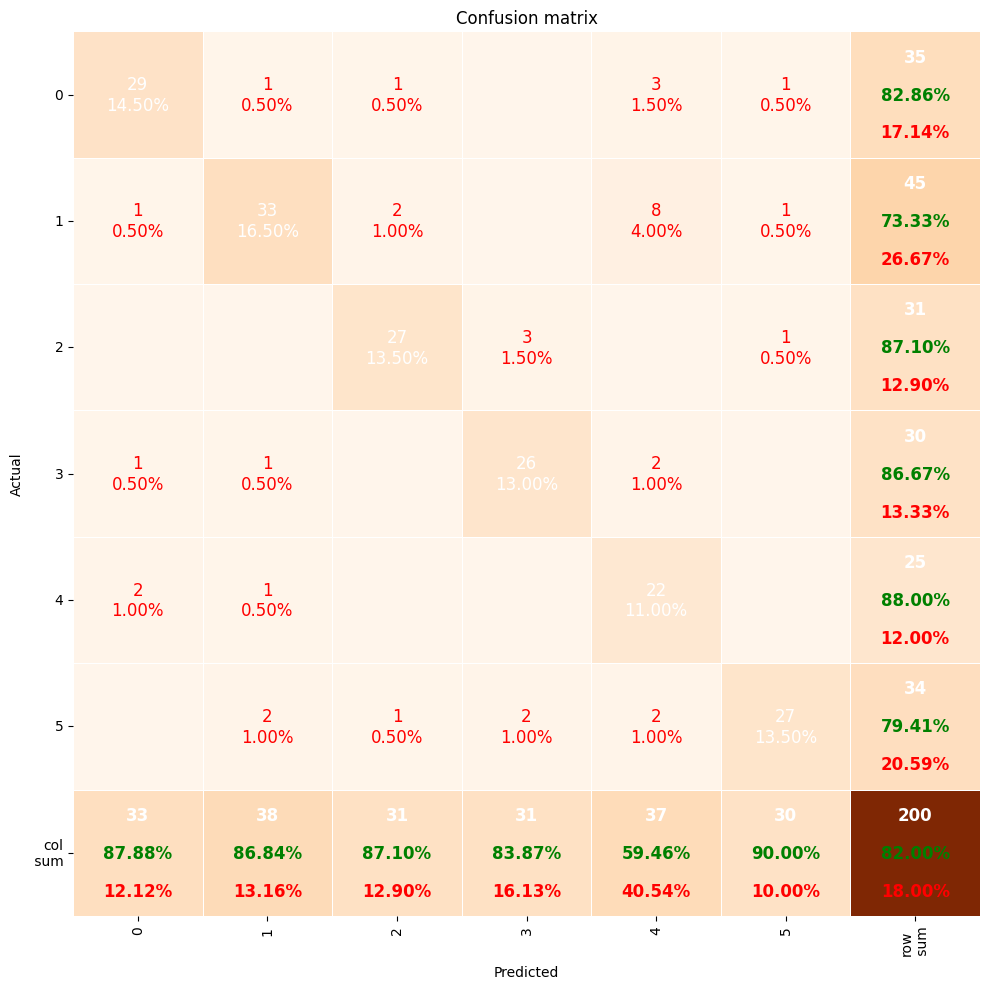

In [7]:
cf = pd.DataFrame(cm)
pretty_plot_confusion_matrix(cf, annot=True, pred_val_axis='x', figsize=(10,10), fz=12)
    

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.83      0.85        35
           2       0.87      0.73      0.80        45
           3       0.87      0.87      0.87        31
           4       0.84      0.87      0.85        30
           5       0.59      0.88      0.71        25
           6       0.90      0.79      0.84        34

    accuracy                           0.82       200
   macro avg       0.83      0.83      0.82       200
weighted avg       0.84      0.82      0.82       200



In [9]:
fig, ax = plt.subplots(figsize=(250, 50))

print(f"Profundidad del árbol: {clf.get_depth()}")
print(f"Número de nodos terminales: {clf.get_n_leaves()}")

plot = plot_tree(
            decision_tree = clf,
            feature_names = X.columns,
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )
plt.savefig('tree.pdf', format='pdf', bbox_inches = "tight")
plt.savefig('tree.png', format='png', bbox_inches = "tight")

Profundidad del árbol: 12
Número de nodos terminales: 93


In [10]:
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_df.head()

,feature,importance
0,housing,0.292674
6,university,0.227035
2,transportation,0.207711
1,food,0.206721
5,health,0.024887


In [11]:
from sklearn.inspection import permutation_importance

results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
feature_importance_dftest = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
})

results = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=0)
feature_importance_dftrain = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': results.importances_mean,
    'importance_std': results.importances_std
})

feature_importance_dftrain = feature_importance_df.sort_values(by='importance', ascending=False)
feature_importance_dftrain.head()

,feature,importance
0,housing,0.292674
6,university,0.227035
2,transportation,0.207711
1,food,0.206721
5,health,0.024887


In [12]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(clf,f) 

In [13]:
from sklearn.tree import _tree

def get_paths_to_class(tree, feature_names, class_value):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    paths = []

    def recurse(node, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], path + [f"{name} <= {threshold:.2f}"])
            recurse(tree_.children_right[node], path + [f"{name} > {threshold:.2f}"])
        else:
            predicted_class = tree_.value[node].argmax()
            if predicted_class == class_value:
                paths.append((path, tree_.value[node]))

    recurse(0, [])
    return paths

feature_names = X_train.columns

class_value = 4  
classes = [0,1, 2, 3, 4, 5]
for i in classes:
    print(f"Class {i}")
    paths_to_class = get_paths_to_class(clf, feature_names, i)

    for path, value in paths_to_class:
        print(f"Path: {path}, Category Distribution: {value}")

Class 0
Path: ['food <= 268.50', 'transportation > 106.00', 'housing <= 707.50', 'university <= 437.92', 'transportation > 124.00', 'university > 254.46', 'housing <= 698.00', 'university > 290.88', 'housing > 685.50', 'transportation <= 137.50'], Category Distribution: [[1. 0. 0. 0. 0. 0.]]
Path: ['food <= 268.50', 'transportation > 106.00', 'housing <= 707.50', 'university <= 437.92', 'transportation > 124.00', 'university > 254.46', 'housing > 698.00', 'health <= 194.00'], Category Distribution: [[1. 0. 0. 0. 0. 0.]]
Path: ['food <= 268.50', 'transportation > 106.00', 'housing <= 707.50', 'university > 437.92', 'housing > 593.00', 'food <= 192.50', 'transportation > 129.00'], Category Distribution: [[1. 0. 0. 0. 0. 0.]]
Path: ['food <= 268.50', 'transportation > 106.00', 'housing > 707.50', 'university <= 319.88', 'food <= 192.50', 'housing > 760.50', 'income <= 1889.50', 'transportation > 119.00'], Category Distribution: [[1. 0. 0. 0. 0. 0.]]
Path: ['food <= 268.50', 'transportatio